In [1]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
movies = pd.read_csv('data/movies.dat', sep='::', names=['movie', 'name', 'genres'])

In [3]:
mlb = MultiLabelBinarizer()

In [4]:
genre_df = pd.DataFrame(mlb.fit_transform(movies['genres'].apply(lambda x: x.split('|'))), columns=mlb.classes_, index=movies.index)

In [5]:
movies = pd.merge(movies.drop('genres', axis='columns'), genre_df, left_index=True, right_index=True)

In [6]:
movies.loc[:, 'year'] = movies.name.apply(lambda x: int(x[-5:-1]))

In [7]:
movies.to_csv('data/processed/movies.csv')

In [8]:
def ohe_col(df, col):
    col_ohe = OneHotEncoder()
    new_df = pd.DataFrame(col_ohe.fit_transform(df[col].values.reshape(-1, 1)).todense(), index=df.index, columns=[f'{col}_{x}' for x in col_ohe.categories_[0]])
    merged_df = pd.merge(new_df, df.drop(col, axis='columns'), left_index=True, right_index=True)
    return merged_df

In [9]:
with open('data/users.dat', 'r') as f:
    lines = f.readlines()

users = pd.DataFrame([x[:-1].split('::') for x in lines], columns=['userid', 'gender', 'age', 'occupation', 'zipcode'])

In [11]:
users = users.drop('zipcode', axis=1)

In [53]:
users

,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,...,age_1,age_18,age_25,age_35,age_45,age_50,age_56,gender_F,gender_M,userid
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6036
6036,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6037
6037,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6038
6038,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6039


In [12]:
cat_columns = ['gender', 'age', 'occupation']#, 'zipcode']

In [13]:
for cat in cat_columns:
    users = ohe_col(users, cat)

In [14]:
users.to_csv('data/processed/users.csv')

In [15]:
ratings = pd.read_csv('data/training.csv')

In [16]:
ratings.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [17]:
def dampened_mean(df, value, product, k=5):
    u = df[value].mean()
    product_rating_counts = df.pivot_table(value, product, aggfunc='count')
    product_rating_counts['avg_value'] = df.groupby(product).mean()[value]
    numerator = (product_rating_counts[value] * product_rating_counts['avg_value'] + (k * u))
    denominator = (product_rating_counts[value] + k)
    product_rating_counts['dampened_mean'] = numerator/denominator
    return product_rating_counts

In [18]:
dampened_mean(ratings, 'rating', 'movie')

,rating,avg_value,dampened_mean
movie,,,
1,1749,4.145226,4.143644
2,566,3.197880,3.201318
3,382,3.023560,3.030885
4,134,2.701493,2.733470
5,237,2.995781,3.008068
...,...,...,...
3948,450,3.720000,3.718577
3949,76,4.328947,4.283363
3950,15,3.133333,3.247620


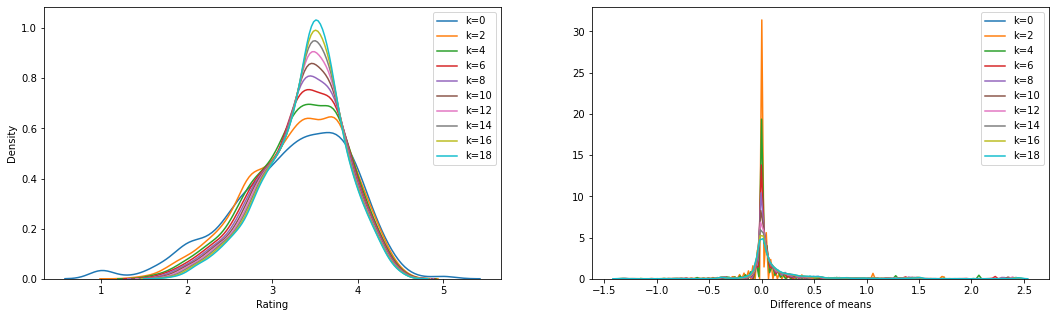

In [19]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(18,5))

for i in range(0, 20, 2):
    dm_df = dampened_mean(ratings, 'rating', 'movie', k=i)
    sns.kdeplot(dm_df['dampened_mean'], label=f'k={i}', ax=ax[0])
    sns.kdeplot(dm_df['dampened_mean'] - dm_df['avg_value'], label=f'k={i}', ax=ax[1])

ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Density')
ax[0].legend()
ax[1].set_xlabel('Difference of means')
ax[1].legend()

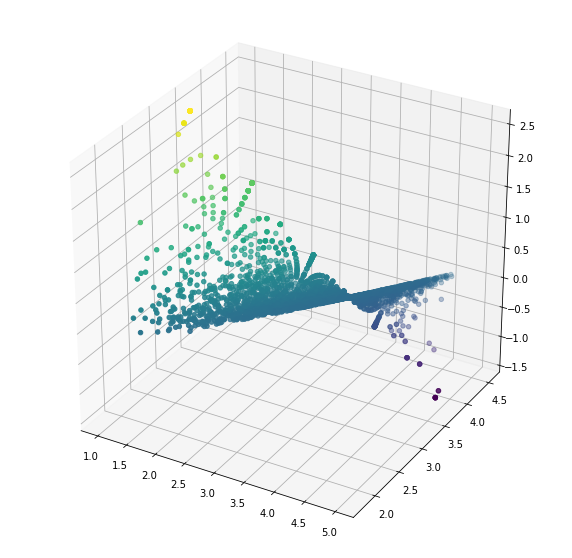

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dm_df['avg_value'], dm_df['dampened_mean'], dm_df['dampened_mean'] - dm_df['avg_value'], c=dm_df['dampened_mean'] - dm_df['avg_value']);

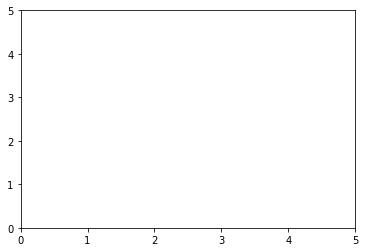

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

In [29]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(
    x=dm_df['avg_value'],
    y=dm_df['dampened_mean'],
    z=np.log(dm_df['rating']),
    mode='markers',
    hovertext=movies.copy().set_index('movie')['name'],
    marker=dict(
        size=1,
        color=dm_df['rating'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(xaxis_type="log", yaxis_type="log")
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [30]:
import pyspark
from pyspark import SparkContext

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [31]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [32]:
schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)])

df_ratings = spark.read.csv('data/training.csv',sep=',', header=True, schema=schema)

In [33]:
df_ratings.show()

+----+-----+------+---------+
|user|movie|rating|timestamp|
+----+-----+------+---------+
|6040|  858|     4|956703932|
|6040|  593|     5|956703954|
|6040| 2384|     4|956703954|
|6040| 1961|     4|956703977|
|6040| 2019|     5|956703977|
|6040| 1419|     3|956704056|
|6040|  573|     4|956704056|
|6040| 3111|     5|956704056|
|6040|  213|     5|956704056|
|6040| 3505|     4|956704056|
|6040| 1734|     2|956704081|
|6040|  912|     5|956704191|
|6040|  919|     5|956704191|
|6040| 2503|     5|956704191|
|6040|  527|     5|956704219|
|6040|  318|     4|956704257|
|6040| 1252|     5|956704257|
|6040|  649|     5|956704257|
|6040| 3289|     5|956704305|
|6040|  759|     5|956704448|
+----+-----+------+---------+
only showing top 20 rows



In [34]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 5399
Number of unique movies: 3662
Number of rating: 800000


In [35]:
train, test = df_ratings.randomSplit([0.8, 0.2], seed=2020)

In [36]:
train.count(), test.count()

(639865, 160135)

In [37]:
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [38]:
rmses = []
models = []

best_model = None
best_rmse = float('inf')

for r in range(4, 10, 2):

    als_model = ALS(userCol='user',
                    itemCol='movie',
                    ratingCol='rating',
                    nonnegative=True,
                    regParam=0.1,
                    rank=r
                   )

    recommender = als_model.fit(train)

    predictions = recommender.transform(test)

    reg_eval = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')

    predictions.describe().show()

    predictions.show()

    reg_eval.evaluate(predictions)

    global_median = predictions.stat.approxQuantile('prediction', [0.5], 0.001)[0]

    predictions_imputed = predictions.na.fill(global_median)

    rmse = reg_eval.evaluate(predictions_imputed)
    
    models.append(recommender)
    rmses.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = recommender

+-------+-----------------+------------------+------------------+-------------------+----------+
|summary|             user|             movie|            rating|          timestamp|prediction|
+-------+-----------------+------------------+------------------+-------------------+----------+
|  count|           160135|            160135|            160135|             160135|    160135|
|   mean|3401.253298779155|1851.7970712211572| 3.590358135323321|9.684013991603272E8|       NaN|
| stddev|1547.130226334602|1086.2746337768026|1.1198946796808622|  5821138.810572089|       NaN|
|    min|              636|                 1|                 1|          956704056|0.13308106|
|    max|             6040|              3952|                 5|          975767289|       NaN|
+-------+-----------------+------------------+------------------+-------------------+----------+

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|31

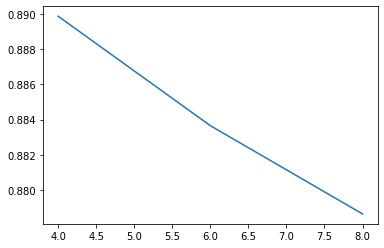

In [42]:
plt.plot(list(range(4, 10, 2)), rmses)

In [39]:
train_preds = best_model.transform(train).toPandas()

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(20)

In [41]:
users.userid

0          1
1          2
2          3
3          4
4          5
        ... 
6035    6036
6036    6037
6037    6038
6038    6039
6039    6040
Name: userid, Length: 6040, dtype: object

In [43]:
users['userid'] = users.userid.apply(lambda x: int(x))

In [44]:
merged_df = pd.merge(train_preds, users, left_on='user', right_on='userid')

In [45]:
merged_df

,user,movie,rating,timestamp,prediction,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,...,age_1,age_18,age_25,age_35,age_45,age_50,age_56,gender_F,gender_M,userid
0,673,148,5,975620824,3.750809,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
1,673,3749,5,975618810,4.118039,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
2,673,3794,2,975619022,3.543858,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
3,673,858,3,975623296,3.829949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
4,673,1084,3,975623169,3.694975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639860,5291,1188,5,961073444,4.661659,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5291
639861,5291,1196,4,961073408,4.032079,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5291
639862,4610,2672,5,964161628,4.435169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4610
639863,4610,3751,4,964161584,4.108473,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4610


In [54]:
merged_df.head()

,user,movie,rating,timestamp,prediction,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,...,age_1,age_18,age_25,age_35,age_45,age_50,age_56,gender_F,gender_M,userid
0,673,148,5,975620824,3.750809,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
1,673,3749,5,975618810,4.118039,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
2,673,3794,2,975619022,3.543858,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
3,673,858,3,975623296,3.829949,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673
4,673,1084,3,975623169,3.694975,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,673


In [49]:
rf.fit(merged_df.drop(['rating', 'user', 'userid', 'timestamp'], axis=1), merged_df.rating)

RandomForestRegressor(n_estimators=20)

In [50]:
test_preds = best_model.transform(test).toPandas()

In [51]:
test_merged_df = pd.merge(train_preds, users, left_on='user', right_on='userid')

test_preds = rf.predict(test_merged_df.drop(['rating', 'user', 'userid', 'timestamp'])

In [62]:
rf.score(test_merged_df.drop(['rating', 'user', 'userid', 'timestamp'], axis=1), test_merged_df.rating)

0.9094849845992288

In [63]:
from sklearn.metrics import mean_squared_error

In [65]:
mean_squared_error(test_merged_df.rating, test_preds) ** 0.5

0.33710939032744186

0.002030819000882544

In [66]:
rmses

[0.88986224575168, 0.8836509478928215, 0.87864406325354]

In [69]:
best_model.

TypeError: 'list' object is not callable

In [67]:
best_rmse

0.87864406325354

In [84]:
predictions_df = predictions_imputed.toPandas()

In [124]:
predictions_df.drop(['timestamp'], axis='columns')

,user,movie,rating,prediction
0,4227,148,2,2.378392
1,3184,148,4,2.630901
2,1150,148,2,2.130629
3,3053,148,3,2.652369
4,2629,463,4,2.895141
...,...,...,...,...
160066,2130,3910,3,3.964851
160067,2710,3910,5,3.072122
160068,1753,3910,4,3.875595
160069,1445,3910,4,2.508086


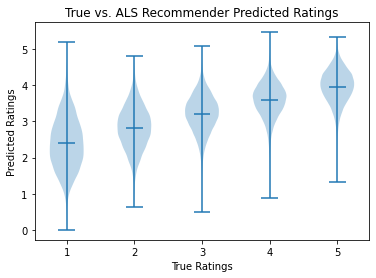

In [85]:
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [75]:
len(set(pd.read_csv('data/requests.csv').user).intersection(set(users.index)))

1782

In [76]:
len(set(pd.read_csv('data/requests.csv').user))

1783

In [78]:
test_schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True)
])

requests_df = spark.read.csv('data/requests.csv',sep=',', header=True, schema=test_schema)

In [80]:
spark_pred_df = best_model.transform(requests_df).toPandas()

In [82]:
dm_df.iloc[]

,rating,avg_value,dampened_mean
movie,,,
1,1749,4.145226,4.139575
2,566,3.197880,3.209981
3,382,3.023560,3.049072
4,134,2.701493,2.806767
5,237,2.995781,3.037759
...,...,...,...
3948,450,3.720000,3.715018
3949,76,4.328947,4.187538
3950,15,3.133333,3.382685


In [108]:
dm_df.iloc[148,:]

rating           125.000000
avg_value          3.664000
dampened_mean      3.654746
Name: 154, dtype: float64

In [103]:
dm_df.index

True

In [104]:
movie_dm = {}

for movie in spark_pred_df.movie:
    try:
        movie_dm[movie] = dm_df.loc[movie, 'dampened_mean']
    except:
        movie_dm[movie] = 1

In [105]:
movie_dm

{148: 3.238394296875,
 463: 2.975065772727273,
 471: 3.6084741833667335,
 496: 3.311247180851064,
 833: 2.5817149,
 1088: 3.342705517699115,
 1238: 3.961096281446541,
 1342: 2.9812387017167383,
 1580: 3.7293599896504137,
 1591: 2.6795819939024392,
 1645: 3.449324666905444,
 1829: 3.2325723500000003,
 1959: 3.6104233657407407,
 2122: 2.616224208542713,
 2142: 2.881926063535911,
 2366: 3.6891376612903226,
 2659: 3.2813195673076927,
 2866: 3.6532690254237288,
 3175: 3.76448897814018,
 3749: 3.332144296875,
 3794: 3.307889813432836,
 3918: 2.85754277972028,
 243: 3.1395622115384616,
 392: 3.1285727083333335,
 540: 2.3539288593750003,
 623: 3.5314308750000003,
 737: 2.1659056412639406,
 858: 4.5090579680063465,
 897: 3.7487486340206186,
 1025: 3.585952572916667,
 1084: 4.079571019624574,
 1127: 3.6889539737021857,
 1395: 3.3226427569169963,
 1460: 2.8132109408602153,
 1483: 2.8383223611111115,
 1507: 3.365267009803922,
 1522: 3.346755340909091,
 1721: 3.585149222705696,
 1896: 3.19324759090

In [123]:
spark_pred_df.prediction[0]

nan

In [125]:
spark_pred_df['dm'] = spark_pred_df.apply(lambda x: movie_dm[x.movie] if np.nan else x.prediction, axis=1)

In [127]:
spark_pred_df.prediction.fillna(spark_pred_df.dm, inplace=True)

In [129]:
spark_pred_df = spark_pred_df.drop('dm', axis=1)

In [133]:
holdout_merged_df = pd.merge(spark_pred_df, users, left_on='user', right_on='userid')

In [134]:
holdout_merged_df

,user,movie,prediction,occupation_0,occupation_1,occupation_10,occupation_11,occupation_12,occupation_13,occupation_14,...,age_1,age_18,age_25,age_35,age_45,age_50,age_56,gender_F,gender_M,userid
0,53,148,3.238394,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,53
1,53,1088,3.342705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,53
2,53,1342,2.981239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,53
3,53,1580,3.729360,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,53
4,53,1591,2.679582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200204,4674,1429,3.660276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4674
200205,1404,3949,3.484363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1404
200206,922,3949,4.218170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,922
200207,1758,3949,4.785573,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1758


In [138]:
holdout_preds = rf.predict(holdout_merged_df.drop(['user', 'userid'],axis=1))

In [143]:
holdout_df = requests_df.toPandas()

In [144]:
holdout_df['rating'] = holdout_preds

In [147]:
holdout_df.to_csv('data/andrew_jacob_submission.csv')

In [119]:
import networkx
from networkx import *

Exception ignored in: <bound method JavaParams.__del__ of ALS_4058a3d3cb9279669d94>
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.3.2/libexec/python/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
  File "/anaconda3/lib/python3.6/site-packages/py4j/java_gateway.py", line 2029, in detach
    java_object._detach()
AttributeError: 'NoneType' object has no attribute '_detach'


In [44]:
G = networkx.graph.Graph()

#Add nodes
G.add_nodes_from(ratings.user, bipartite=0)
G.add_nodes_from(ratings.movie, bipartite=1)


G.add_weighted_edges_from(list(zip(ratings.user, ratings.movie, ratings.rating)))

In [45]:
print("radius: %d" % radius(G))
 
print("diameter: %d" % diameter(G))
 
print("eccentricity: %s" % eccentricity(G))
 
print("center: %s" % center(G))
 
print("periphery: %s" % periphery(G))
 
print("density: %s" % density(G))


KeyboardInterrupt: 

In [46]:

def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.nodes[user]['bipartite'] == 'users'

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)

    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity]

user_nodes = get_nodes_from_partition(G, 'users')
project_nodes = get_nodes_from_partition(G, 'projects')

print(most_similar_users(G, 'u4560', user_nodes, project_nodes))

NameError: name 'get_nodes_from_partition' is not defined